# Simulating an *AR(2)* process and making forecasts

The purpose of this notebook is creating an Auto-Regressive process of second order and analyzing it to make forecasts. First, let's view what a Auto-Regressive process is.

## Defining an Auto-Regressive process

> **Auto-Regressive process**: 
> In time series, an **$AR(q)$** model is a linear combination of a constant $C$, the present error term $\epsilon_t$ which is also white noise, and the past values of the series $y_{t-p}$. The magnitude of the influence of the past values on the present value is denoted as $\phi_p$, which represents the coefficients of the $AR(p) $ model, where $p$ is the order. The general expression of an $AR(p)$ model is: Matehmatically, this is:
$$y_t = C + \epsilon_t + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p}$$

> The order $p$ of the AR model determines the number of past error terms that affect the present value.
### Process to identify a MA model
The next diagram shows the steps to identify a AR model.


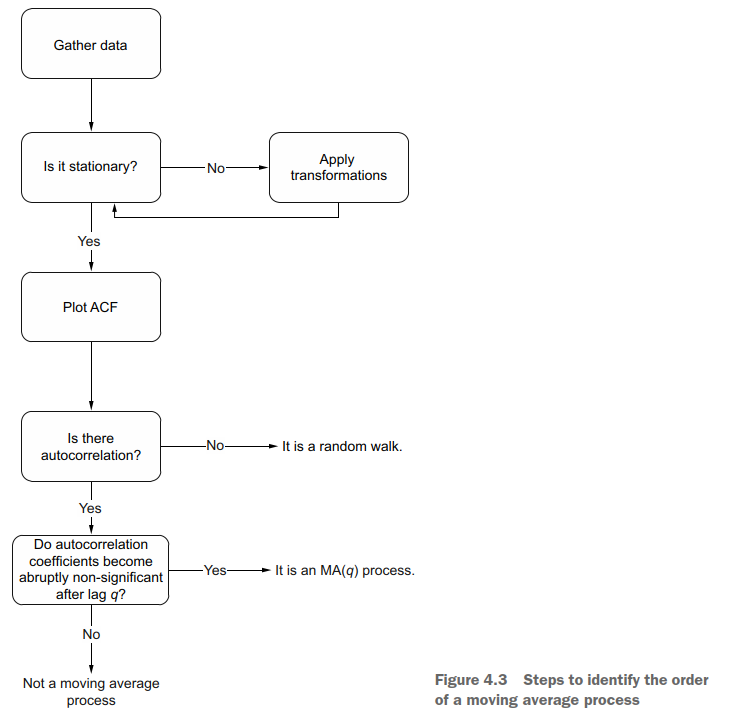

------------------------

## Actions to execute
In this notebook, we will simulate a AR(2) process from the equation:
$$y_t = 0.33 y_{t-1} + 0.50 y_{t-2}$$
The actions to execute are:
1. Gather data: Simulate de AR(2) model with the above equation.
2. Test stationary.
    - Apply transformations until our series is stationary.
4. Plot ACF: Is it slowly decaying?
5. Plot the PACF:get the order of our AR model.
6. Make forecasts over the test: use rolling forecast with a window lenght of the AR's order.
7. Plot forecasting.

## Part 1. Gather data

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

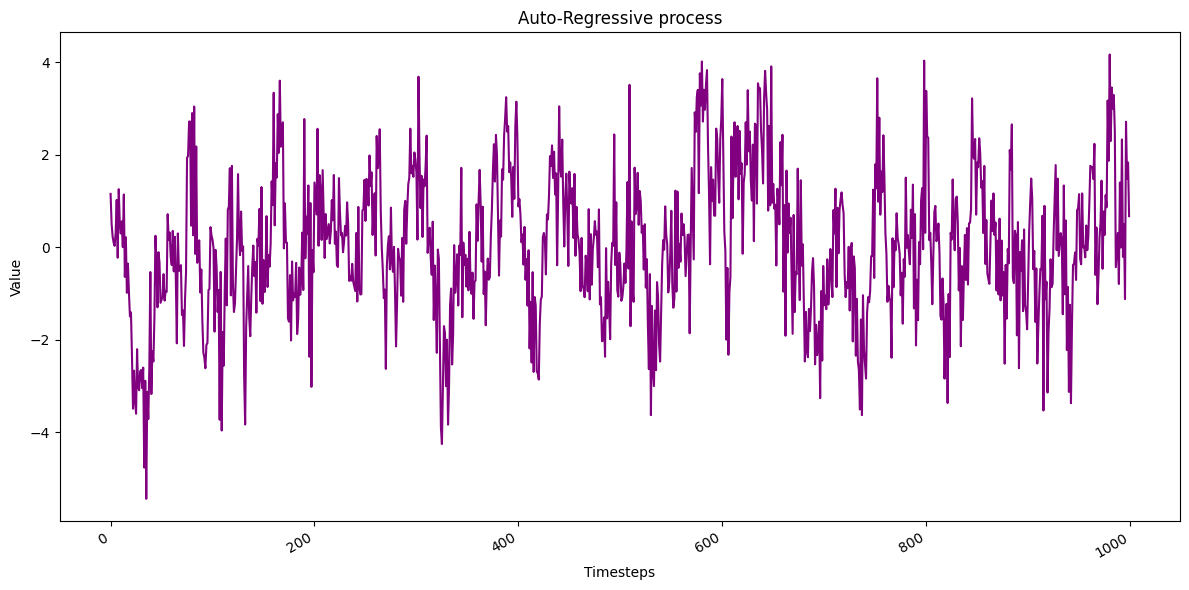

In [3]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(AR2_process, color='purple')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Auto-Regressive process')
fig.autofmt_xdate()
plt.tight_layout()

## Par 2. Test stationary

To test stationary, Augmented Dickey-Fuller test will be used.

In [4]:
ADF_result = adfuller(AR2_process)

print(f'ADF Statistic: {ADF_result[0]:.2f}')
print(f'p-value: {ADF_result[1]:}')

ADF Statistic: -7.79
p-value: 8.124147224917656e-12


Since the $p-$value is lower than a significance of 0.5, our TS is stationary.

## Par 3. Plot ACF

Let's get the Autocorrelation Coefficients of our stationary-time series.

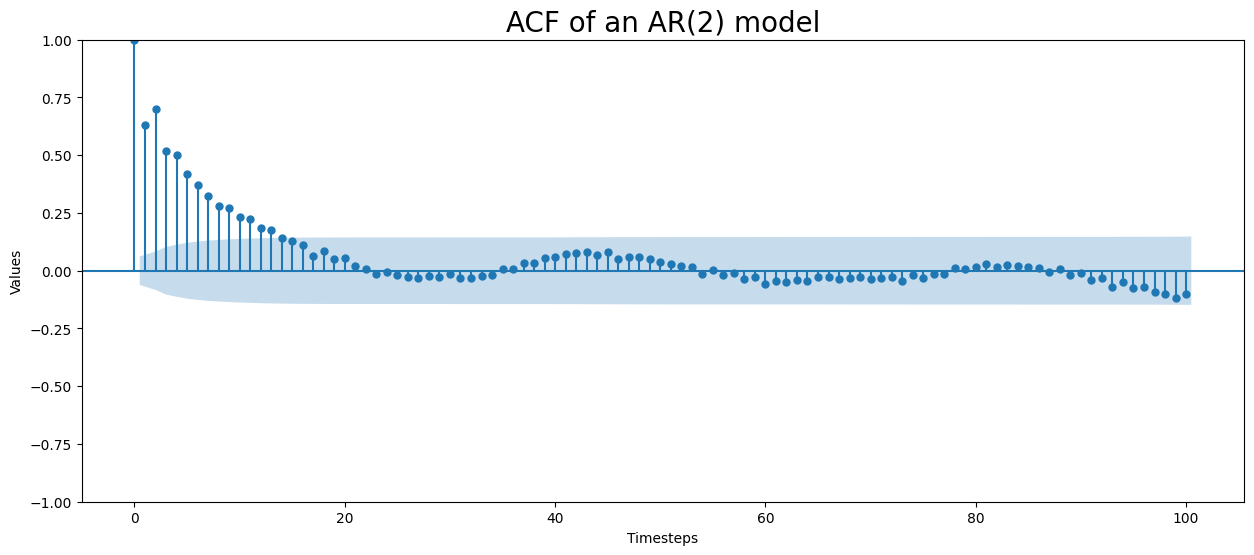

In [5]:
n_coef = 100

fig, ax = plt.subplots(figsize=(15,6))

# applying ACF
plot_acf(AR2_process, ax=ax, lags=n_coef)
ax.set(xlabel='Timesteps', ylabel='Values', title = 'ACF of an AR(2) model')
ax.title.set_size(20)
plt.show()

This ACF plot shows an slow decay. So, it is can NOT be approximed as a MA model.

## Par 3. Plot PACF

Let's get the Partial Autocorrelation Coefficients of our stationary-time series.

/home/jt-cantilever/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


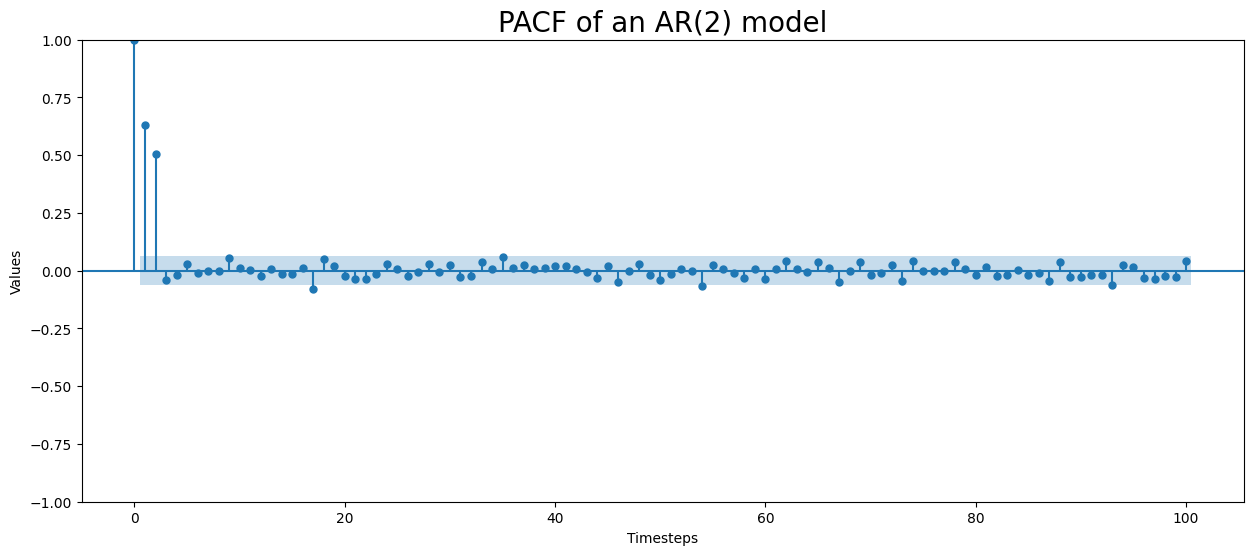

In [6]:
n_coef = 100

fig, ax = plt.subplots(figsize=(15,6))

# applying ACF
plot_pacf(AR2_process, ax=ax, lags=n_coef)
ax.set(xlabel='Timesteps', ylabel='Values', title = 'PACF of an AR(2) model')
ax.title.set_size(20)
plt.show()

With this plot, we can see that the order of the AR model is 2.

## Part 5. Forecasting

Here, we will use ***rolling forecasting*** method with SARIMAX. The rolling method consists on training the model using SARIMAX and forecasting $p=2$ steps in the future, then, we train our model again with the new data and forecast the next two steps and so on, until all the test data has been forecasting to compare the final model.

In [7]:
# definig data as df
df_data = pd.DataFrame({'value': AR2_process})

# splitting data
train = df_data[:800]
test = df_data[800:]

In [8]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    """
    This function applys the rolling forecast method using SARIMAX in time series, ie,
    the model is train with the train data, then it is used to forecast the next n(window) steps. 
    After that, the model is trained again with the new data to forecast the next n(window) steps,
    and so on, until all the horizon steps have been forecasted.
    
    Parameters:
        df (pd.DataFrame): dataframe with the data.
        train_len (int): lenght of the train data.
        test_len (int): lenght of the test data.
        horizon (int): number of total steps to forecast.
        window (int): nuumber of steps to forecast in each iteration.
    
    Return:
        pred_MA (list): list with all the predictions.
    """
    total_len = train_len + horizon

    pred_MA = []

    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=(0,0,2))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_MA.extend(oos_pred)
    
    return pd.DataFrame(pred_MA, columns=['pred_AR2']).reset_index(drop=True)

In [9]:
# Traingn and testing
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_AR2 = rolling_forecast(df_data, TRAIN_LEN, HORIZON, WINDOW)

test = pd.concat([test.reset_index(drop=True), pred_AR2], axis=1)
test.reset_index(drop=True, inplace=True)
test.index = test.index + 800

test.head()

,value,pred_AR2
800,3.385647,1.760765
801,2.404726,-0.301890
802,2.370444,1.612553
803,0.157693,1.120425
804,0.316872,-0.047333


## Part 6. Plotting and testing our forecasting

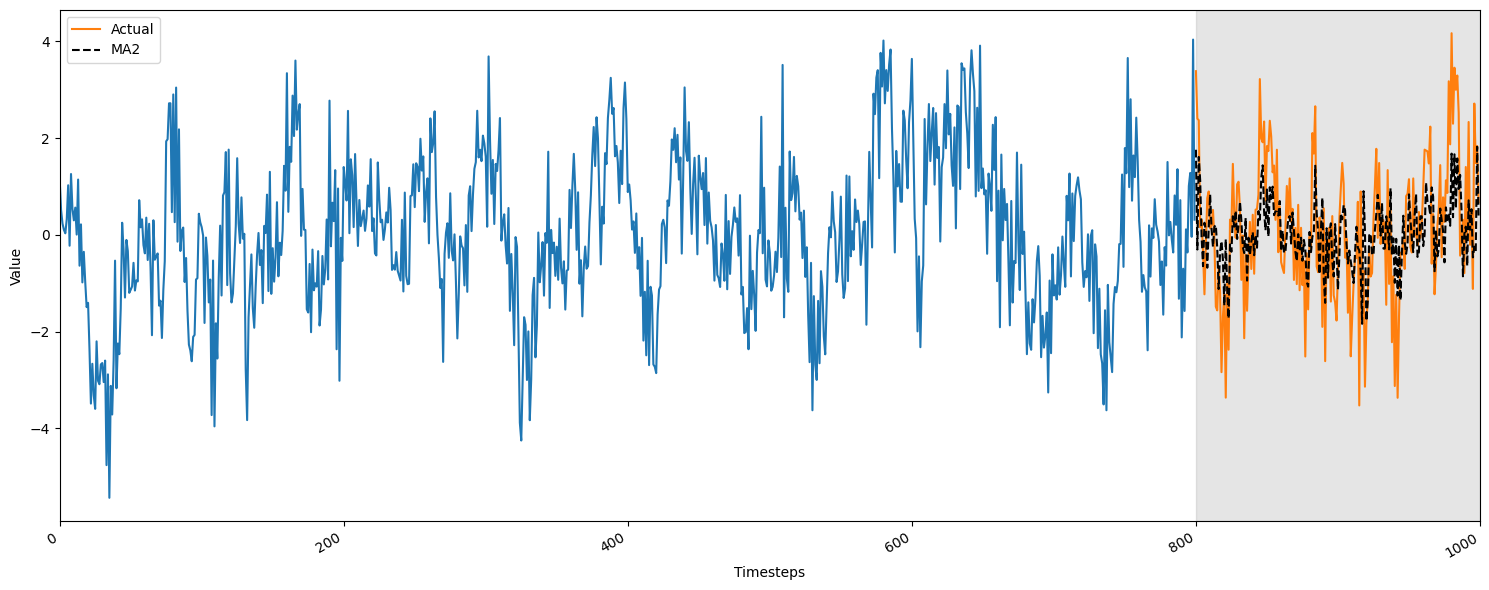

In [10]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_AR2'], 'k--', label='MA2')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(0, 1000)
fig.autofmt_xdate()
plt.tight_layout()

In [13]:
# test using MSE
mse_AR = mean_squared_error(test['value'], test['pred_AR2'])
mse_AR

1.3573325292688354

The MSE is too low, so that our model was a good perfomance.